In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# Style (clean / NMI-like)
# -------------------------
plt.rcParams["figure.dpi"] = 150
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.22
plt.rcParams["font.size"] = 9
plt.rcParams["legend.frameon"] = False
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.labelsize"] = 9
plt.rcParams["xtick.labelsize"] = 8
plt.rcParams["ytick.labelsize"] = 8

TABLES_DIR = os.path.join("..", "results", "tables")
SUMMARY_CSV = os.path.join(TABLES_DIR, "exp14_multicity_tabular_summary.csv")
WEIGHTS_LONG_CSV = os.path.join(
    TABLES_DIR,
    "exp14_multicity_tabular_summary_peer_weights_long.csv",
)

df = pd.read_csv(SUMMARY_CSV)
wlong = pd.read_csv(WEIGHTS_LONG_CSV)

print("Summary:", df.shape, "Weights long:", wlong.shape)
df.head()


Summary: (12, 37) Weights long: (144, 7)


,City,HorizonSteps,MeanFlow_Test,Local_MAE_Ratio,Persist_MAE,Skill_vs_Persist,Local_Train_MAE,Global_Train_MAE,Local_MAE,Global_MAE,...,TopKMass3,NumNonZeroWeights,NumTrain,NumVal,NumTest,NumFitSamples,NumEvalSamples,NumPeers,CacheHash,ModelType
0,augsburg,12,176.366060,0.211077,49.539360,0.248540,37.065620,46.822324,37.226824,45.156014,...,0.872639,9,300000,200000,200000,4000,4000,12,64621706ccd1,histgb
1,bremen,12,204.206700,0.274933,71.308900,0.212678,56.521058,62.694709,56.143096,60.138611,...,0.663790,9,300000,200000,200000,4000,4000,12,64621706ccd1,histgb
2,cagliari,12,287.789500,0.294039,106.727700,0.207129,79.635354,96.388821,84.621339,96.438315,...,0.928148,7,300000,200000,200000,4000,4000,12,64621706ccd1,histgb
3,darmstadt,12,154.499800,0.288315,57.396800,0.223919,41.343587,54.268827,44.544557,55.089908,...,0.896258,8,300000,200000,200000,4000,4000,12,64621706ccd1,histgb
4,essen,12,248.952939,0.172487,74.328568,0.422280,38.695223,55.996864,42.941126,60.001903,...,0.957267,9,150368,49983,50000,4000,4000,12,64621706ccd1,histgb


In [ ]:
df = df.copy()
df["RelDelta_Router"] = df["Delta_Router"] / df["Local_MAE"].replace(0.0, np.nan)
df["RelDelta_Global"] = df["Delta_Global"] / df["Local_MAE"].replace(0.0, np.nan)

# Identify the largest PIER city (often the outlier)
outlier_city = df.loc[df["PIER"].idxmax(), "City"]
print("Outlier city by PIER:", outlier_city)

df_out = df[df["City"] == outlier_city].iloc[0]
df_out[["City","PIER","Delta_Router","Delta_Global","Local_MAE","Global_MAE","Router_MAE","Persist_MAE","Skill_vs_Persist"]]


Outlier city by PIER: luzern


City                    luzern
PIER                 65.181386
Delta_Router        -30.404761
Delta_Global        -30.406025
Local_MAE           121.472198
Global_MAE           91.066173
Router_MAE           91.067438
Persist_MAE         118.518745
Skill_vs_Persist      -0.02492
Name: 6, dtype: object

In [ ]:
def corr_table(df_in: pd.DataFrame, tag: str) -> pd.DataFrame:
    rows = []
    for col, label in [
        ("Delta_Router", "ΔRouter"),
        ("Delta_Global", "ΔGlobal"),
        ("RelDelta_Router", "RelΔRouter"),
        ("RelDelta_Global", "RelΔGlobal"),
        ("Local_MAE_Ratio", "Local_MAE_Ratio"),
        ("Skill_vs_Persist", "Skill_vs_Persist"),
    ]:
        if col not in df_in.columns:
            continue
        pear = df_in["PIER"].corr(df_in[col], method="pearson")
        spear = df_in["PIER"].corr(df_in[col], method="spearman")
        rows.append({"Subset": tag, "Y": label, "Pearson_r": pear, "Spearman_r": spear})
    return pd.DataFrame(rows)

df_all = df.copy()
df_wo = df[df["City"] != outlier_city].copy()

ct = pd.concat(
    [corr_table(df_all, "All cities"),
     corr_table(df_wo, f"Exclude outlier ({outlier_city})")],
    ignore_index=True,
)
ct.round(3)


,Subset,Y,Pearson_r,Spearman_r
0,All cities,ΔRouter,-0.230,0.217
1,All cities,ΔGlobal,-0.242,0.441
2,All cities,RelΔRouter,-0.218,0.049
3,All cities,RelΔGlobal,-0.341,0.014
4,All cities,Local_MAE_Ratio,0.175,-0.266
5,All cities,Skill_vs_Persist,-0.262,-0.231
6,Exclude outlier (luzern),ΔRouter,0.707,0.582
7,Exclude outlier (luzern),ΔGlobal,0.866,0.873
8,Exclude outlier (luzern),RelΔRouter,0.441,0.364
9,Exclude outlier (luzern),RelΔGlobal,0.227,0.318


In [ ]:
def fit_line(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    m = np.isfinite(x) & np.isfinite(y)
    x = x[m]
    y = y[m]
    if x.size < 2:
        return np.nan, np.nan, np.nan
    b, a = np.polyfit(x, y, 1)  # y = a + b x
    yhat = a + b * x
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan
    return a, b, r2

def scatter_cost(ax, df_in, ycol, title, annotate_cities=None):
    x = df_in["PIER"].values
    y = df_in[ycol].values
    cities = df_in["City"].values

    ax.scatter(x, y, s=26, alpha=0.9)

    a, b, r2 = fit_line(x, y)
    r = pd.Series(x).corr(pd.Series(y), method="pearson")

    if np.isfinite(a) and np.isfinite(b):
        xs = np.linspace(np.nanmin(x), np.nanmax(x), 200)
        ax.plot(xs, a + b * xs, linestyle="--", linewidth=1.0)

    ax.set_xlabel("PIER")
    ax.set_ylabel(ycol)
    ax.set_title(title)

    ax.text(
        0.98, 0.02,
        f"r={r:.3f}\n$R^2$={r2:.3f}",
        transform=ax.transAxes,
        ha="right", va="bottom",
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.85),
    )

    if annotate_cities:
        for name in annotate_cities:
            m = pd.Series(cities).str.lower() == str(name).lower()
            if m.any():
                i = int(np.where(m)[0][0])
                ax.scatter(x[i], y[i], s=52, edgecolor="black", linewidth=0.9)
                ax.text(
                    x[i], y[i], str(cities[i]),
                    fontsize=7, ha="left", va="bottom",
                    bbox=dict(boxstyle="round,pad=0.15", fc="white", ec="none", alpha=0.8),
                )


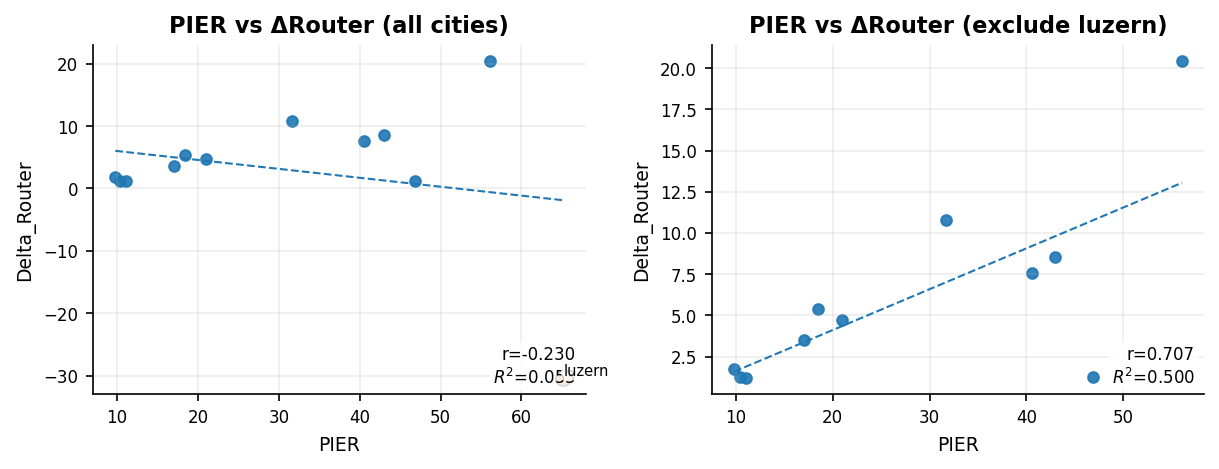

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8.2, 3.2), sharey=False)

scatter_cost(
    axes[0], df_all, "Delta_Router",
    "PIER vs ΔRouter (all cities)",
    annotate_cities=[outlier_city, "paris", "munich", "madrid"],
)

scatter_cost(
    axes[1], df_wo, "Delta_Router",
    f"PIER vs ΔRouter (exclude {outlier_city})",
    annotate_cities=["paris", "munich", "madrid"],
)

plt.tight_layout()
plt.show()


In [ ]:
def assign_quadrant(df_in: pd.DataFrame, pier_q=75.0, rel_eps=0.05) -> pd.DataFrame:
    d = df_in.copy()
    thr = float(np.percentile(d["PIER"].values, pier_q))
    d["PIER_thr"] = thr

    d["RelDelta_Router"] = d["Delta_Router"] / d["Local_MAE"].replace(0.0, np.nan)

    labels = []
    for _, r in d.iterrows():
        high = r["PIER"] >= thr
        dr = r["Delta_Router"]
        rel = r["RelDelta_Router"]
        near0 = np.isfinite(rel) and (abs(rel) < rel_eps)

        if high and dr > 0:
            lab = "Valuable uniqueness"
        elif high and dr <= 0:
            lab = "Harmful uniqueness"
        elif (not high) and near0:
            lab = "Redundant"
        elif (not high) and dr > 0:
            lab = "Under-served"
        else:
            lab = "Mixed"
        labels.append(lab)

    d["QuadrantLabel"] = labels
    return d

df_q = assign_quadrant(df_all, pier_q=75.0, rel_eps=0.05)
df_q["QuadrantLabel"].value_counts()


QuadrantLabel
Under-served           6
Redundant              3
Valuable uniqueness    2
Harmful uniqueness     1
Name: count, dtype: int64

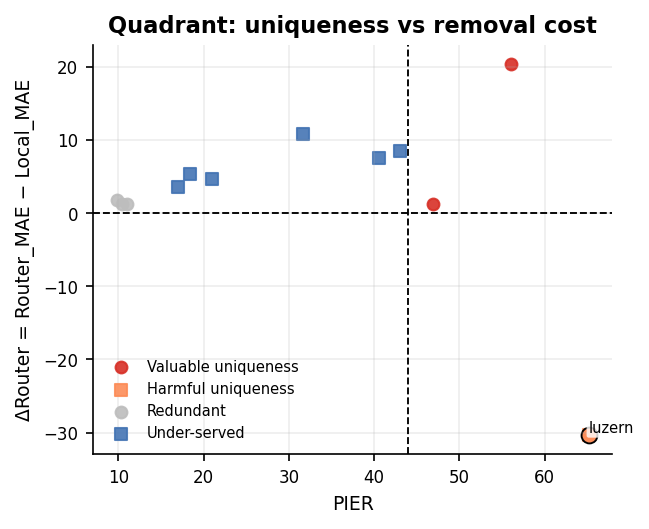

In [ ]:
def plot_quadrant(df_q: pd.DataFrame):
    thr = df_q["PIER_thr"].iloc[0]

    cats = ["Valuable uniqueness", "Harmful uniqueness", "Redundant", "Under-served", "Mixed"]
    cmap = {
        "Valuable uniqueness": "#d73027",
        "Harmful uniqueness": "#fc8d59",
        "Redundant": "#bdbdbd",
        "Under-served": "#4575b4",
        "Mixed": "#91bfdb",
    }
    mmap = {
        "Valuable uniqueness": "o",
        "Harmful uniqueness": "s",
        "Redundant": "o",
        "Under-served": "s",
        "Mixed": "o",
    }

    fig, ax = plt.subplots(figsize=(4.4, 3.6))

    for cat in cats:
        sub = df_q[df_q["QuadrantLabel"] == cat]
        if sub.empty:
            continue
        ax.scatter(
            sub["PIER"], sub["Delta_Router"],
            s=32, alpha=0.9,
            color=cmap[cat],
            marker=mmap[cat],
            label=cat,
        )

    ax.axvline(thr, linestyle="--", linewidth=0.9, color="black")
    ax.axhline(0.0, linestyle="--", linewidth=0.9, color="black")

    ax.set_xlabel("PIER")
    ax.set_ylabel("ΔRouter = Router_MAE − Local_MAE")
    ax.set_title("Quadrant: uniqueness vs removal cost")

    for name in [outlier_city, "paris", "munich", "madrid"]:
        m = df_q["City"].str.lower() == str(name).lower()
        if m.any():
            r = df_q[m].iloc[0]
            ax.scatter(r["PIER"], r["Delta_Router"], s=58, edgecolor="black", linewidth=0.9, color=cmap[r["QuadrantLabel"]])
            ax.text(
                r["PIER"], r["Delta_Router"], r["City"],
                fontsize=7, ha="left", va="bottom",
                bbox=dict(boxstyle="round,pad=0.15", fc="white", ec="none", alpha=0.8),
            )

    ax.legend(loc="best", fontsize=7)
    plt.tight_layout()
    plt.show()

plot_quadrant(df_q)


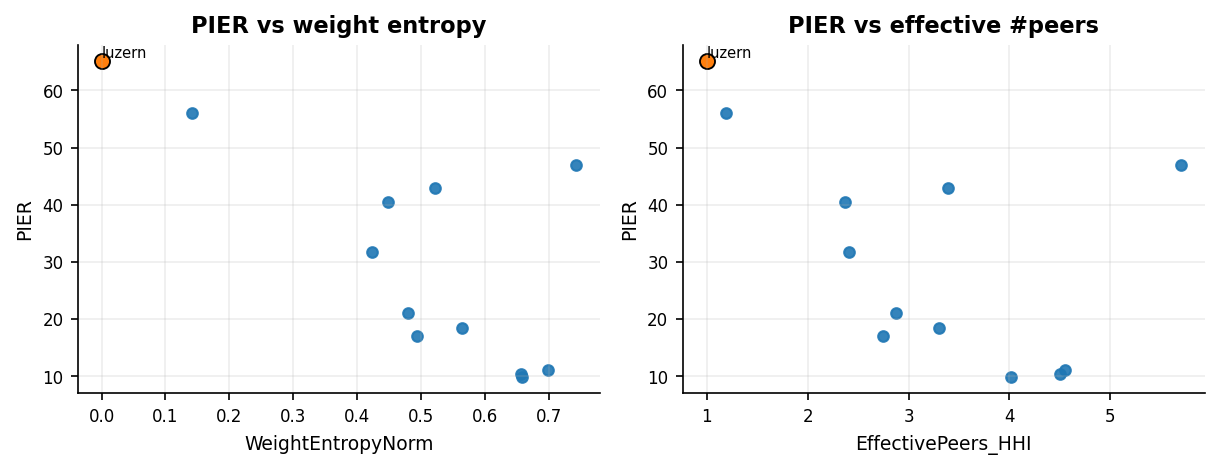

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8.2, 3.2), sharey=False)

axes[0].scatter(df["WeightEntropyNorm"], df["PIER"], s=26, alpha=0.9)
axes[0].set_xlabel("WeightEntropyNorm")
axes[0].set_ylabel("PIER")
axes[0].set_title("PIER vs weight entropy")

axes[1].scatter(df["EffectivePeers_HHI"], df["PIER"], s=26, alpha=0.9)
axes[1].set_xlabel("EffectivePeers_HHI")
axes[1].set_ylabel("PIER")
axes[1].set_title("PIER vs effective #peers")

for ax in axes:
    for name in [outlier_city, "paris", "munich", "madrid"]:
        m = df["City"].str.lower() == str(name).lower()
        if m.any():
            r = df[m].iloc[0]
            x = r["WeightEntropyNorm"] if ax is axes[0] else r["EffectivePeers_HHI"]
            y = r["PIER"]
            ax.scatter(x, y, s=52, edgecolor="black", linewidth=0.9)
            ax.text(x, y, r["City"], fontsize=7, ha="left", va="bottom")

plt.tight_layout()
plt.show()


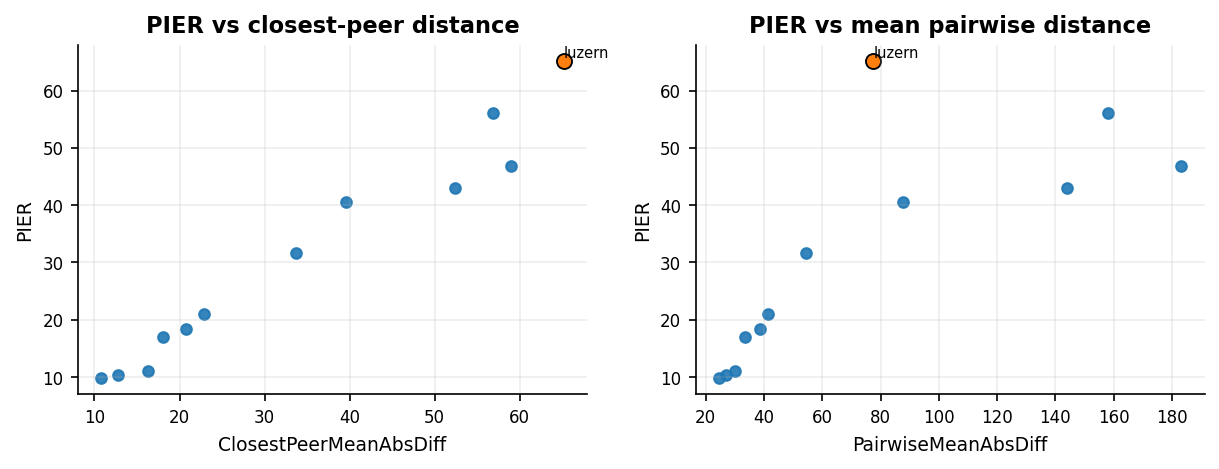

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8.2, 3.2), sharey=False)

axes[0].scatter(df["ClosestPeerMeanAbsDiff"], df["PIER"], s=26, alpha=0.9)
axes[0].set_xlabel("ClosestPeerMeanAbsDiff")
axes[0].set_ylabel("PIER")
axes[0].set_title("PIER vs closest-peer distance")

axes[1].scatter(df["PairwiseMeanAbsDiff"], df["PIER"], s=26, alpha=0.9)
axes[1].set_xlabel("PairwiseMeanAbsDiff")
axes[1].set_ylabel("PIER")
axes[1].set_title("PIER vs mean pairwise distance")

for ax in axes:
    for name in [outlier_city, "paris", "munich", "madrid"]:
        m = df["City"].str.lower() == str(name).lower()
        if m.any():
            r = df[m].iloc[0]
            x = r["ClosestPeerMeanAbsDiff"] if ax is axes[0] else r["PairwiseMeanAbsDiff"]
            y = r["PIER"]
            ax.scatter(x, y, s=52, edgecolor="black", linewidth=0.9)
            ax.text(x, y, r["City"], fontsize=7, ha="left", va="bottom")

plt.tight_layout()
plt.show()


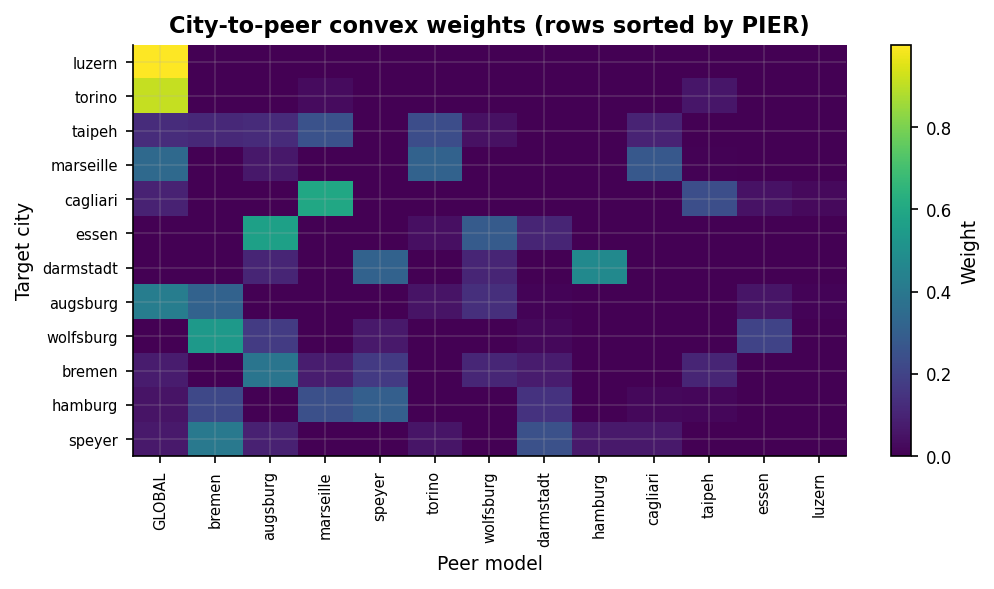

In [ ]:
# Build a pivot matrix: rows = cities, cols = peers, values = weights
W = wlong.pivot_table(index="City", columns="PeerName", values="Weight", aggfunc="mean").fillna(0.0)

# Sort rows by PIER descending (more interpretable)
city_order = df.sort_values("PIER", ascending=False)["City"].tolist()
W = W.reindex(city_order)

# Sort columns by overall mass (global importance)
col_mass = W.sum(axis=0).sort_values(ascending=False)
W = W[col_mass.index.tolist()]

plt.figure(figsize=(7.0, 4.0))
im = plt.imshow(W.values, aspect="auto", interpolation="nearest")

plt.yticks(np.arange(len(W.index)), W.index, fontsize=7)
plt.xticks(np.arange(len(W.columns)), W.columns, rotation=90, ha="center", fontsize=7)

plt.title("City-to-peer convex weights (rows sorted by PIER)")
plt.xlabel("Peer model")
plt.ylabel("Target city")
plt.colorbar(im, label="Weight")
plt.tight_layout()
plt.show()


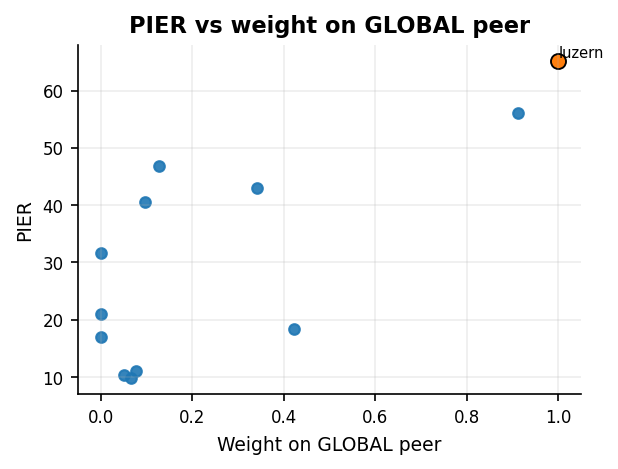

In [ ]:
# Share assigned to GLOBAL peer in the convex mixture
global_share = wlong[wlong["PeerName"] == "GLOBAL"][["City","Weight"]].rename(columns={"Weight":"GlobalWeight"})
global_share = global_share.merge(df[["City","PIER","Delta_Router"]], on="City", how="left")

plt.figure(figsize=(4.2, 3.2))
plt.scatter(global_share["GlobalWeight"], global_share["PIER"], s=26, alpha=0.9)

plt.xlabel("Weight on GLOBAL peer")
plt.ylabel("PIER")
plt.title("PIER vs weight on GLOBAL peer")

for name in [outlier_city, "paris", "munich", "madrid"]:
    m = global_share["City"].str.lower() == str(name).lower()
    if m.any():
        r = global_share[m].iloc[0]
        plt.scatter(r["GlobalWeight"], r["PIER"], s=52, edgecolor="black", linewidth=0.9)
        plt.text(r["GlobalWeight"], r["PIER"], r["City"], fontsize=7, ha="left", va="bottom")

plt.tight_layout()
plt.show()
